# Timeseries forecasting for weather prediction

## Setup

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchinfo import summary
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os
import time
import sys
from urllib import request
import zipfile

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

- Dataset : Jena Climate
- Info :
    - recorded by the Max Planck Institute for Biogeochemistry
    - 14 features (temperature, pressure, humidity, etc.)
    - recorded once per 10 minutes
    - Location : Weather Station, Max Planck Instiute for Biogeochemistry in Jena, Germany
    - Time-frame Considered: Jan 10, 2009 - December 31, 2016

|Index|Features|Format|Description|
|----|----|----|:----|
|1|Date Time|01.01.2009 00:10:00|Date-time reference|
|2|p (mbar)|996.52|The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.|
|3|T (degC)|-8.02|Temperature in Celsius|
|4|Tpot (K)|265.4|Temperature in Kelvin|
|5|Tdew (degC)|-8.9|Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.|
|6|rh (%)|93.3|Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.|
|7|VPmax (mbar)|3.33|Saturation vapor pressure|
|8|VPact (mbar)|3.11|Vapor pressure|
|9|VPdef (mbar)|0.22|Vapor pressure deficit|
|10|sh (g/kg)|1.94|Specific humidity|
|11|H2OC (mmol/mol)|3.12|Water vapor concentration|
|12|rho (g/m ** 3)|1307.75|Airtight|
|13|wv (m/s)|1.03|Wind speed|
|14|max. wv (m/s)|1.75|Maximum wind speed|
|15|wd (deg)|152.3|Wind direction in degrees|

In [3]:
annotation_folder = os.path.abspath(".") + "/dataset/"
url = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
savefile = os.path.join(annotation_folder, os.path.basename(url))

if not os.path.exists(annotation_folder):
    os.makedirs(annotation_folder)
    print('Folder creation complete!')
else:
    print('The folder already exists.')

if not os.path.isfile(savefile):
    request.urlretrieve(url, savefile)
    with zipfile.ZipFile(savefile, 'r') as zip_ref:
        zip_ref.extractall(annotation_folder)
    print('File creation complete!')
else:
    print('The File already exists.')

The folder already exists.
The File already exists.


In [56]:
df = pd.read_csv(savefile)

In [57]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


## Raw Data Visualization

To give us a sense of the data we are working with, each feature has been plotted below. This shows the distinct pattern of each feature over the time period from 2009 to 2016. It also shows where anomalies are present, which will be addressed during normalization.

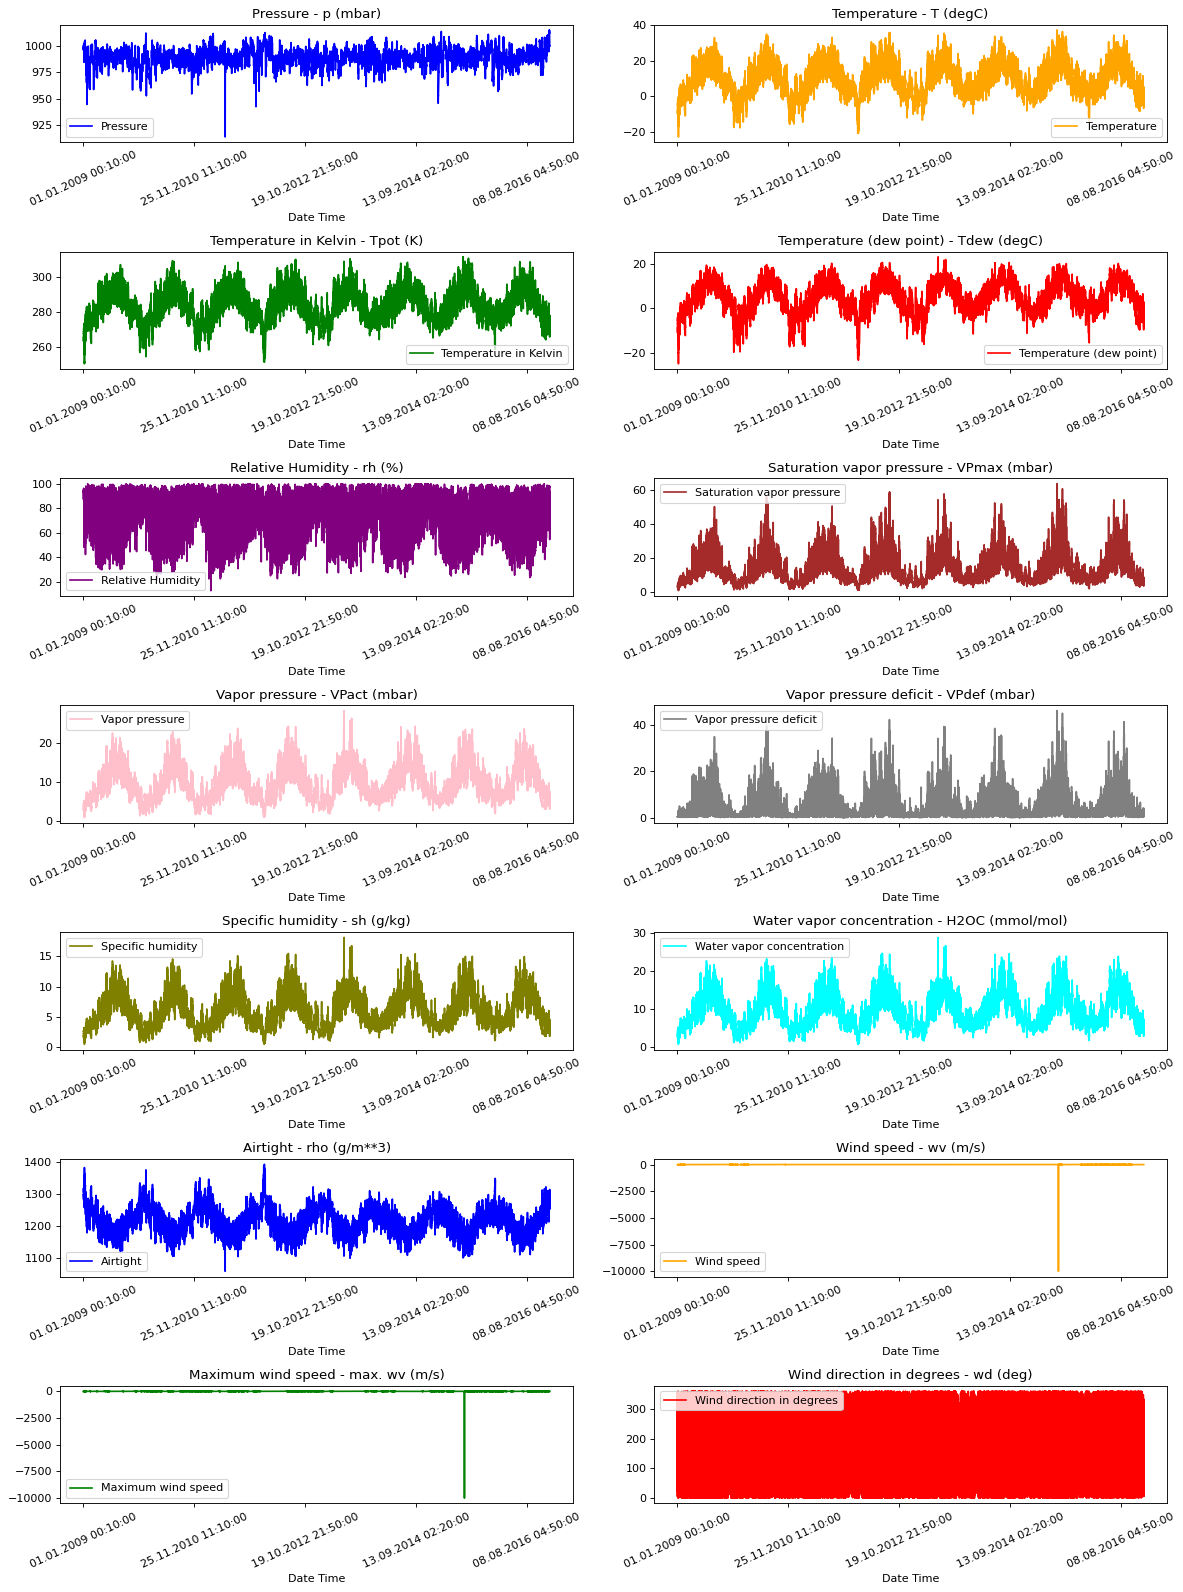

In [6]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

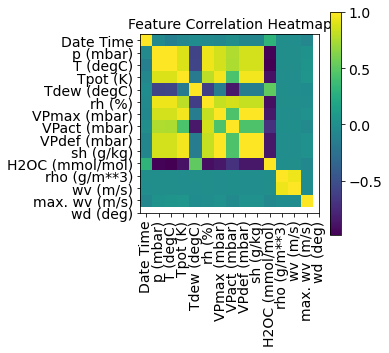

In [7]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

## Data Preprocessing

- Train, Valid 비율 : 0.715 & 0.285
- 과거 720개의 timestamp(720/6=120시간)의 데이터를 input으로 하고, 72개의 timestamp(72/6=12시간) 이후의 온도를 예측
- [0, 1]로 정규화 (MinMax)

In [45]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 10

params = {
    'learning_rate': 0.001,
    'batch_size': 256,
    'epochs': 10,
    'dim': 7,
    'lstm_hidden_dim': 32,
    'lstm_layer': 1
          }

In [9]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]

scaler = MinMaxScaler().fit(features)
features = scaler.transform(features)
features = pd.DataFrame(features)

train_data = features.loc[0:train_split - 1]
val_data = features.loc[train_split:]

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


In [19]:
print(f'length of train dataset: {len(train_data)}, length of validation dataset: {len(val_data)}')

length of train dataset: 300693, length of validation dataset: 119858


In [11]:
selected_features

['p (mbar)',
 'T (degC)',
 'VPmax (mbar)',
 'VPdef (mbar)',
 'sh (g/kg)',
 'rho (g/m**3)',
 'wv (m/s)']

In [12]:
features

,0,1,2,3,4,5,6
0,0.814939,0.248632,0.037886,0.004782,0.081679,0.743213,0.997262
1,0.815430,0.242163,0.036294,0.004564,0.078843,0.749349,0.997231
2,0.815037,0.240504,0.035976,0.004347,0.078276,0.750666,0.997178
3,0.814840,0.243822,0.036772,0.004130,0.080545,0.747523,0.997193
4,0.814840,0.244485,0.036931,0.004130,0.080545,0.746954,0.997191
...,...,...,...,...,...,...,...
420546,0.849828,0.314480,0.056829,0.026516,0.088486,0.699003,0.997226
420547,0.848452,0.326091,0.060809,0.031298,0.089053,0.688407,0.997272
420548,0.847371,0.329242,0.061923,0.033688,0.087918,0.685264,0.997267
420549,0.847273,0.311494,0.055874,0.027385,0.084515,0.700739,0.997307


## Training dataset

The training dataset labels starts from the 792nd observation (720 + 72).

In [13]:
start = past + future   # 720 + 72 = 792
end = start + train_split   # 792 + 300693 = 301485

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)  # 720 / 6 = 120

In [14]:
x_end = len(val_data) - past - future   # 119858 - 720 - 72 = 119066

label_start = train_split + past + future   # 300693 + 720 + 72 = 301485

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

In [16]:
y_train

,1
792,0.141815
793,0.148117
794,0.156742
795,0.163045
796,0.175651
...,...
301480,0.574059
301481,0.565268
301482,0.572898
301483,0.578869


In [28]:
print(f'shape of X : {x_train.shape}, shape of y : {y_train.shape}')

shape of X : (300693, 7), shape of y : (300693, 1)


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, y, sequence_length=120, step=6, stride=1):
        self.X = X
        self.y = y
        self.sequence_length = sequence_length
        self.step = step
        self.stride = stride

        self.valid_idxs = [i for i in range(0, len(X)-self.sequence_length*self.step+1)]
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]

    def __len__(self):
        return len(self.valid_idxs)

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + self.sequence_length*self.step
        input_sequence = np.array(self.X[i:last:self.step], dtype=np.float32)
        target = np.array(self.y.iloc[i], dtype=np.float32)
        return torch.from_numpy(input_sequence), torch.from_numpy(target)

In [ ]:
DataLoader_params = {'batch_size': params['batch_size'],
          'shuffle': True,
          'num_workers': 4,
          'pin_memory' : True
         }

train_dataset = CustomDataset(x_train, y_train, sequence_length, step)
val_dataset = CustomDataset(x_val, y_val, sequence_length, step)
train_loader = DataLoader(dataset=train_dataset, **DataLoader_params)
params['shuffle'] = False
val_loader = DataLoader(dataset=val_dataset, **DataLoader_params)

In [ ]:
print(next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape)

In [ ]:
input_shape = next(iter(train_loader))[0].shape

## Training

In [38]:
class FORECASTING_MODEL(nn.Module):
    def __init__(self, params):
        super(FORECASTING_MODEL, self).__init__()
        self.rnn = nn.LSTM(input_size=params['dim'], hidden_size=params['lstm_hidden_dim'])
        self.linear = nn.Linear(params['lstm_hidden_dim'], 1)

    def forward(self, input):
        x, _ = self.rnn(input)
        x = x[:, -1, :]
        x = self.linear(x)
        return x

In [46]:
model = FORECASTING_MODEL(params).to(device)

In [47]:
summary(model, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
FORECASTING_MODEL                        --                        --
├─LSTM: 1-1                              [256, 120, 32]            5,248
├─Linear: 1-2                            [256, 1]                  33
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
Total mult-adds (M): 161.23
Input size (MB): 0.86
Forward/backward pass size (MB): 7.87
Params size (MB): 0.02
Estimated Total Size (MB): 8.75

In [48]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

In [49]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [50]:
def train(model, train_data, optimizer, loss_fn, use_fp16=True, max_norm=None, progress_display=False):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    progress = ProgressMeter(
        len(train_data),
        [batch_time, losses],
        prefix="Epoch: [{}]".format(epoch))

    model.train()
    end = time.time()
    for idx, [x, y] in enumerate(train_data):
        optimizer.zero_grad(set_to_none=True)
        scaler = torch.cuda.amp.GradScaler()

        input = x.to(device).float()
        target = y.to(device).float()

        with torch.cuda.amp.autocast(enabled=use_fp16):
            predictions = model(input)
            train_loss = loss_fn(predictions, target)
        if use_fp16:
            scaler.scale(train_loss).backward()
            if max_norm is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            train_loss.backward()
            if max_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            optimizer.step()

        losses.update(train_loss.item(), input.size(0))
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if progress_display == True and idx % 50 == 0:
            progress.display(idx)

    return losses.avg

In [51]:
def validation(model, val_data, loss_fn):
    losses = AverageMeter('Loss', ':.4e')
    model.eval()
    for idx, [x, y] in enumerate(val_data):
        input = x.to(device).float()
        target = y.to(device).float()
        with torch.no_grad():
            predictions = model(input)
            val_loss = loss_fn(predictions, target)
        losses.update(val_loss.item(), input.size(0))

    return losses.avg

In [52]:
class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print(f'\n Training process is stopped early....')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

In [53]:
%%time
best = {"loss": sys.float_info.max}
history = dict()
early_stopping = EarlyStopping(patience=5, verbose=1)

for epoch in range(1, epochs+1):
    epoch_loss = train(model, train_loader, optimizer, loss_fn, use_fp16=False)
    val_loss = validation(model, val_loader, loss_fn)

    history.setdefault('loss', []).append(epoch_loss)
    history.setdefault('val_loss', []).append(val_loss)

    print(f"[Train] Epoch : {epoch:^3}"
          f"  Train Loss: {epoch_loss:.4}"
          f"  Valid Loss: {val_loss:.4}")

    if val_loss > best["loss"]:
        best["state"] = seg.state_dict()
        best["epoch"] = epoch
    if early_stopping.validate(val_loss):
        break

[Train] Epoch :  1   Train Loss: 0.01042  Valid Loss: 0.005722
[Train] Epoch :  2   Train Loss: 0.005799  Valid Loss: 0.005749
[Train] Epoch :  3   Train Loss: 0.005739  Valid Loss: 0.005768
[Train] Epoch :  4   Train Loss: 0.005712  Valid Loss: 0.005767
[Train] Epoch :  5   Train Loss: 0.005697  Valid Loss: 0.00575
[Train] Epoch :  6   Train Loss: 0.005677  Valid Loss: 0.005728
[Train] Epoch :  7   Train Loss: 0.005667  Valid Loss: 0.005772

 Training process is stopped early....
CPU times: user 2min 49s, sys: 11.1 s, total: 3min
Wall time: 2min 58s


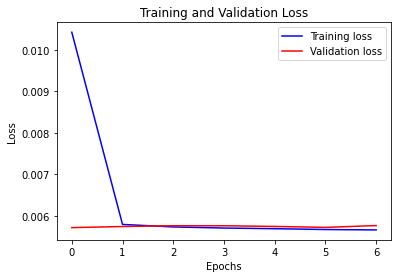

In [54]:
def visualize_loss(history, title):
    loss = history["loss"]
    val_loss = history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

## Prediction

The trained model above is now able to make predictions for 5 sets of values from validation set.

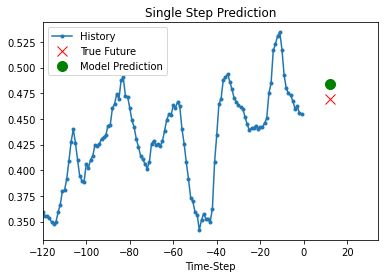

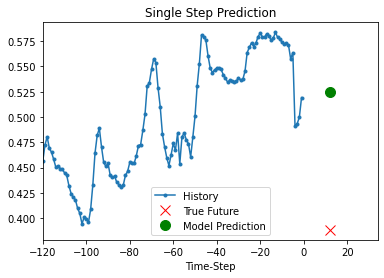

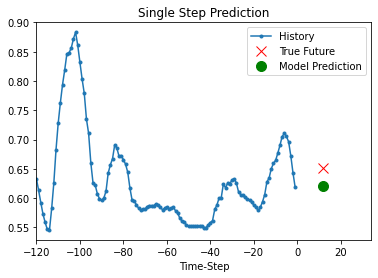

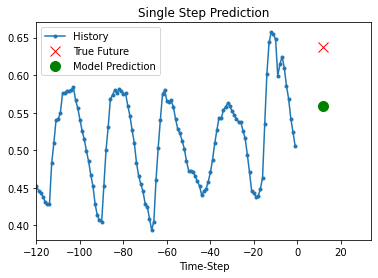

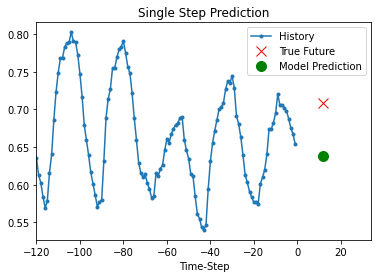

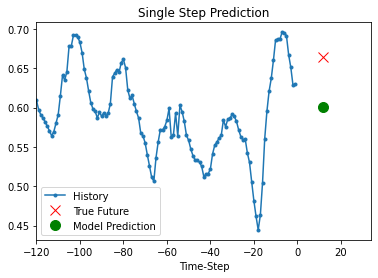

In [55]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

for i, (x, y) in enumerate(val_loader):
    if i > 5:
        break
    else:
        input = torch.unsqueeze(x[0], 0).to(device).float()
        output = model(input).cpu().detach().numpy()
        show_plot(
            [x[0][:, 1].numpy(), y[0].numpy(), model(input).cpu().detach().numpy()],
            12,
            "Single Step Prediction",
        )

---